# 🧭 Atividade 2 — Clusterização de Centros de Distribuição

### 📌 Descrição do Problema

O desafio proposto consiste em analisar dados de falhas de entrega da empresa e, a partir disso, identificar agrupamentos geográficos que possam indicar onde novos **centros de distribuição** deveriam ser implantados para melhorar a logística.

A base de dados contém:
- **Latitude e Longitude**: localização onde houve falha na entrega
- **Price**: valor da entrega associada àquela localização

O objetivo final é propor a **quantidade ideal de centros de retirada**, utilizando técnicas de clusterização.

---

### 🎯 Estratégia para Resolução

A resolução será conduzida em etapas:

1. **Leitura e tratamento dos dados**
   - Correção de formatação de números (separadores decimais)
   - Conversão dos campos para tipo numérico (`float`)
   - Verificação de valores nulos ou inconsistentes

2. **Análise exploratória**
   - Visualização da dispersão geográfica dos pontos
   - Análise de distribuição de valores de entrega

3. **Clusterização geográfica**
   - Aplicação do algoritmo **KMeans**
   - Determinação do número ideal de clusters com o **método do cotovelo**
   - Agrupamento das entregas com base na localização

4. **Cálculo de indicadores por cluster**
   - Soma total dos valores de entrega por cluster
   - Visualização dos agrupamentos com centroide

5. **Conclusão**
   - Interpretação dos resultados e recomendação de posicionamento de centros de distribuição

---

### ✅ Objetivo Final

Entregar um modelo de clusterização funcional, com visualização e explicação técnica, que ajude a empresa a **tomar decisões sobre onde localizar centros de retirada para minimizar falhas de entrega**.


# Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
from branca.element import Template, MacroElement


from geopy.geocoders import Nominatim
import time

# **Leitura e tratamento dos dados**

In [1]:
# Recarregar o dataset com separador decimal correto
file_path = "Geolocalização Dataset.csv"
df = pd.read_csv(file_path)
df

,latitude,longitude,price
0,"-21,591360","-51,066690","52,47"
1,"-21,285350","-49,654970","37,03"
2,"-22,025900","-47,067020","71,50"
3,"-21,916230","-46,686660","88,27"
4,"-22,476390","-46,632780","36,16"
...,...,...,...
648,"-21,180190","-48,654820","80,53"
649,"-20,193540","-50,479400","82,64"
650,"-23,546670","-47,437780","81,67"
651,"-20,480100","-50,012660","17,69"


## Verificar os tipos das Colunas

In [2]:
print("Tipos de dados por coluna:")
df.dtypes


Tipos de dados por coluna:


latitude     object
longitude    object
price        object
dtype: object

### ⚠️ Problema com os Tipos de Dados

Durante a inspeção inicial do dataset, foi identificado que as colunas `latitude`, `longitude` e `price` estão com o tipo `object`.

Isso acontece porque os valores numéricos foram carregados como **strings**, devido ao uso da **vírgula (`,`) como separador decimal**, um formato comum em arquivos com padrão brasileiro.

---

### 🛠️ Solução Proposta

Para tornar os dados compatíveis com as operações numéricas e algoritmos de machine learning (como clusterização), será necessário:

1. Substituir as vírgulas por pontos nas colunas `latitude`, `longitude` e `price`
2. Converter essas colunas do tipo `object` para o tipo `float`

Esse tratamento permitirá:
- Realizar cálculos de distância entre pontos geográficos
- Aplicar algoritmos de clusterização (como KMeans)
- Gerar visualizações quantitativas precisas


## Transformação de dados

In [3]:
# Substituir vírgulas por ponto e converter para float
df['latitude'] = df['latitude'].str.replace(',', '.').astype(float)
df['longitude'] = df['longitude'].str.replace(',', '.').astype(float)
df['price'] = df['price'].str.replace(',', '.').astype(float)

# Verificar os novos tipos de dados
print("Tipos após conversão:")
df.dtypes


Tipos após conversão:


latitude     float64
longitude    float64
price        float64
dtype: object

## Verificação de Nulos

In [4]:
# Verificar valores ausentes após conversão
print("Valores nulos por coluna:")
print(df.isnull().sum())


Valores nulos por coluna:
latitude     0
longitude    0
price        0
dtype: int64


## 🗺️ Visualização Geográfica das Entregas

### 🎯 Objetivo

Nesta etapa, vamos criar um gráfico de dispersão geográfica (`scatterplot`) com base nas colunas `latitude` e `longitude`, representando os locais com falha na entrega.

Além disso, usaremos uma escala de cores para indicar o valor da entrega (`price`) em cada ponto.

### 🔍 Por que isso é importante?

- Identificar visualmente **regiões mais densas de falhas**
- Observar se há **padrões espaciais ou anomalias**
- Ajudar na escolha do melhor algoritmo de clusterização (ex: KMeans ou DBSCAN)
- Avaliar se valores mais altos estão concentrados em determinadas áreas



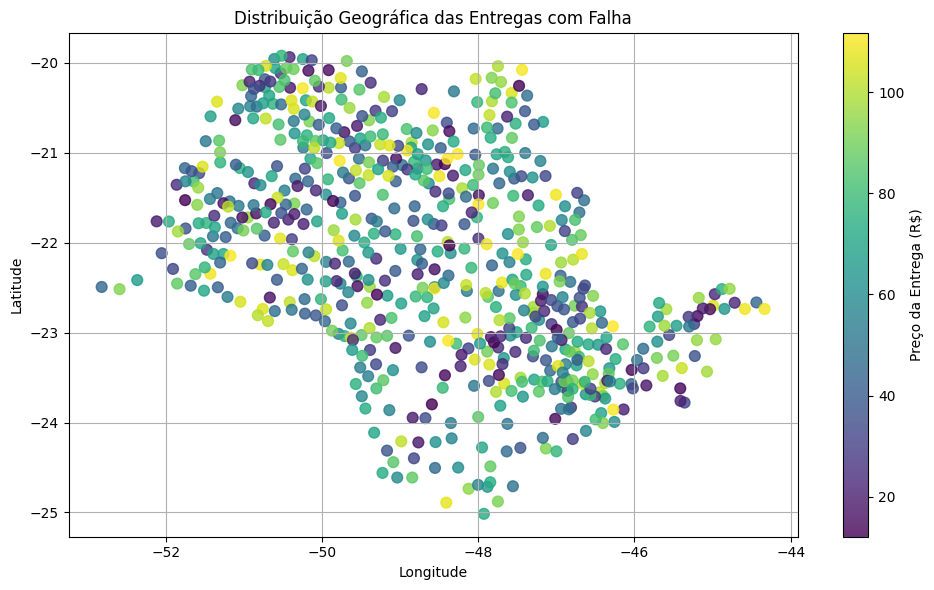

In [5]:

# Criar scatterplot geográfico com escala de cor pelo preço da entrega
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['price'], cmap='viridis', s=60, alpha=0.8)
plt.colorbar(scatter, label='Preço da Entrega (R$)')
plt.title('Distribuição Geográfica das Entregas com Falha')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()


#### 🔍 Análise da Distribuição Geográfica

- Os pontos estão **bem agrupados em regiões com alta densidade**, o que é ideal para aplicação de algoritmos como o **KMeans**.
- A distribuição cobre uma região que se assemelha ao estado de **São Paulo**, com **alta concentração no interior**.
- Os valores das entregas (`price`) estão **espalhados entre os pontos**, o que indica que o **valor da entrega não define a localização das falhas**.
- Isso reforça que a **distribuição geográfica é o principal fator a ser considerado** para determinar os agrupamentos e propor centros de distribuição.
---

## 📊 Definição da Quantidade Ideal de Clusters — Método do Cotovelo

### 🎯 Objetivo

Antes de aplicar a clusterização com KMeans, é necessário determinar a quantidade ideal de agrupamentos. Para isso, utilizaremos o **método do cotovelo**, que avalia a **inércia** (variabilidade intra-cluster) para diferentes valores de `k`.

### 🧪 Estratégia

1. Testar valores de `k` entre 1 e 10
2. Calcular a inércia (soma das distâncias dos pontos ao centro do cluster)
3. Gerar um gráfico com os valores de inércia por `k`
4. Identificar o “cotovelo” do gráfico — o ponto onde o ganho de performance se estabiliza — para escolher o número ideal de clusters


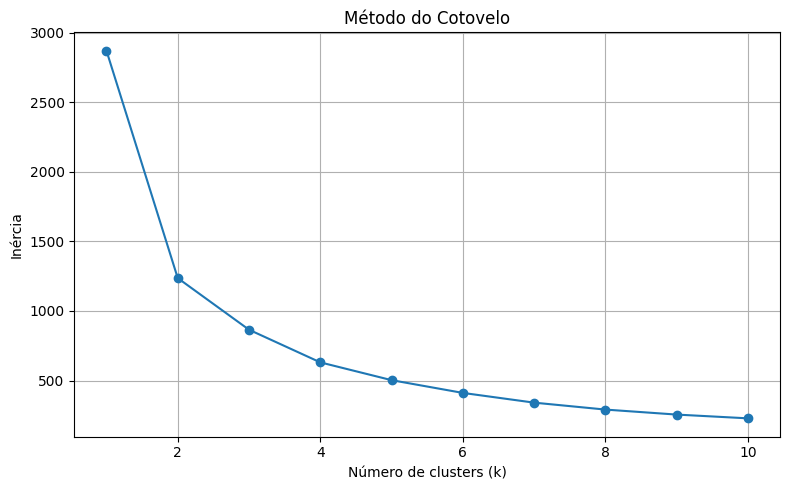

In [6]:
X = df[['latitude', 'longitude']]

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia')
plt.grid(True)
plt.tight_layout()
plt.show()


## 📈 Análise do Método do Cotovelo

O gráfico do método do cotovelo mostra a relação entre o número de clusters (`k`) e a inércia (soma das distâncias dos pontos ao centroide de seus clusters).

### 🔍 Interpretação:
- Observa-se uma queda acentuada da inércia entre `k=1` e `k=4`
- A partir de `k=4`, o ganho na redução da inércia começa a diminuir, formando um ponto de inflexão na curva

### ✅ Conclusão:
Com base no método do cotovelo, o número ideal de clusters para este problema parece ser **k = 4**.

---


## 📍 Clusterização com KMeans (k=4)

Aplicamos o algoritmo KMeans com 4 clusters, conforme definido pelo método do cotovelo.  
Cada ponto foi atribuído a um grupo com base em sua localização geográfica (`latitude`, `longitude`).


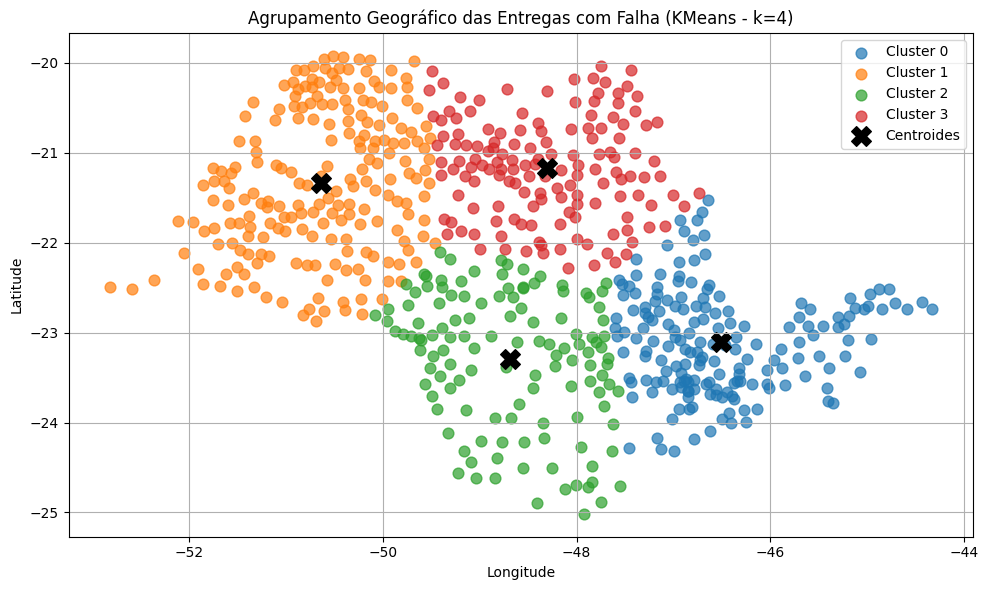

In [7]:


# Aplicar KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])
centroides = kmeans.cluster_centers_

# Plotar cada cluster com legenda separada
plt.figure(figsize=(10, 6))

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                label=f'Cluster {cluster_id}', s=60, alpha=0.7)

# Adicionar os centroides
plt.scatter(centroides[:, 1], centroides[:, 0], c='black', s=200, marker='X', label='Centroides')

# Configurações do gráfico
plt.title('Agrupamento Geográfico das Entregas com Falha (KMeans - k=4)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualização:
- Cada grupo é representado por uma cor diferente
- Os centroides dos clusters estão destacados com um marcador preto "X"
- A distribuição confirma agrupamentos geograficamente coerentes, facilitando a definição de centros de distribuição otimizados

## 📌 Análise da Clusterização (k=4)

- Os 4 grupos apresentam **distribuições geográficas coesas**, sem grandes sobreposições.
- Os **centroides estão estrategicamente posicionados**, indicando que podem representar bons candidatos a **centros de distribuição regionais**.
- A divisão geográfica é **coerente com a densidade dos dados** observada anteriormente na análise exploratória.

---

## 🎯 Próximo passo sugerido

### ➕ Calcular o valor total de entregas por cluster

Esse cálculo permitirá:

- Avaliar o **potencial de movimentação financeira** por região
- **Priorizar investimentos logísticos** em clusters com maior volume financeiro
- Identificar quais centros podem exigir mais infraestrutura para atender a demanda



## 💰 Análise Financeira por Cluster

Agora que os dados foram agrupados em 4 regiões geográficas, vamos calcular:

- A quantidade de entregas por cluster
- A soma total dos valores de entrega em cada região
- A média por entrega

Essas informações ajudarão a definir **a importância estratégica de cada centro de distribuição** com base no valor financeiro que movimenta.


In [8]:
# Soma do valor das entregas por cluster
valor_por_cluster = df.groupby('cluster')['price'].agg(['count', 'sum', 'mean']).reset_index()
valor_por_cluster.columns = ['Cluster', 'Total de Entregas', 'Soma dos Valores (R$)', 'Média por Entrega (R$)']

# Exibir os resultados
valor_por_cluster


,Cluster,Total de Entregas,Soma dos Valores (R$),Média por Entrega (R$)
0,0,175,11067.97,63.245543
1,1,207,12838.25,62.020531
2,2,126,7837.20,62.200000
3,3,145,9440.39,65.106138


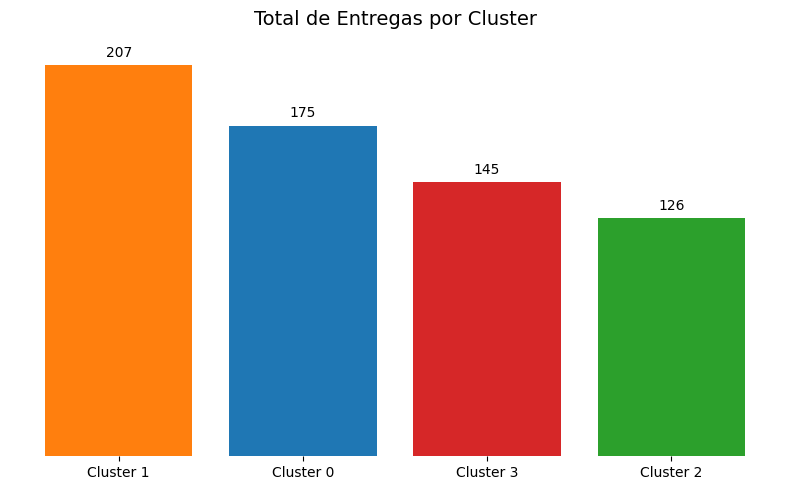

In [9]:

valor_por_cluster['Cluster'] = valor_por_cluster['Cluster'].astype(str)
valor_por_cluster['Cluster'] = 'Cluster ' + valor_por_cluster['Cluster']

# Adicionar cores fixas
valor_por_cluster['Cor'] = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Ordenar por número de entregas (decrescente)
df_ordenado = valor_por_cluster.sort_values(by='Total de Entregas', ascending=False)

# Plot com nomes reais no eixo X
plt.figure(figsize=(8, 5))
bars = plt.bar(
    x=range(len(df_ordenado)),
    height=df_ordenado['Total de Entregas'],
    color=df_ordenado['Cor'],
    tick_label=df_ordenado['Cluster']  # nomes corretos agora!
)

plt.title('Total de Entregas por Cluster', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

# Remover bordas e grid
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(False)

# Adicionar valores sobre as barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 3,
             f'{int(yval)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


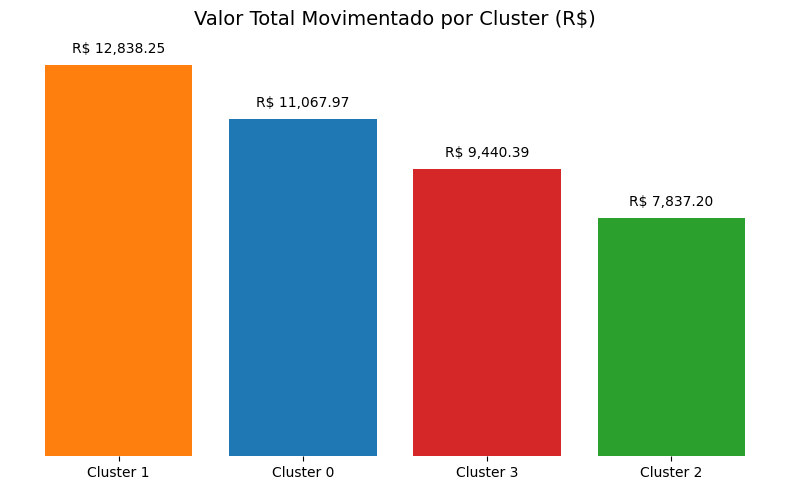

In [10]:
# Plotar gráfico de barras
plt.figure(figsize=(8, 5))
bars = plt.bar(
    x=range(len(df_ordenado)),
    height=df_ordenado['Soma dos Valores (R$)'],
    color=df_ordenado['Cor'],
    tick_label=df_ordenado['Cluster']  # exibir "Cluster 1", etc.
)

plt.title('Valor Total Movimentado por Cluster (R$)', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])

# Estilo limpo
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.grid(False)

# Adicionar valor sobre cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 300,
             f'R$ {yval:,.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 🔍 Análise Cruzada: Volume de Entregas x Valor Movimentado

A análise dos dois indicadores principais — **quantidade de entregas com falha** e **valor total movimentado** — permite uma avaliação mais estratégica sobre **quais regiões devem ser priorizadas na alocação de centros de distribuição**.


### 🎯 Principais Insights:

- **Cluster 1** lidera em **volume de entregas e valor total**, sendo a **região de maior prioridade estratégica**.
- **Cluster 0** também apresenta alta demanda e movimentação financeira, reforçando a necessidade de um centro regional robusto.
- **Cluster 3** tem menos entregas, mas um **ticket médio mais alto**, o que indica **entregas mais valiosas ou clientes estratégicos**.
- **Cluster 2** aparece como o menos expressivo em ambas as métricas, mas ainda relevante para garantir **cobertura total e equilíbrio logístico**.

---

### ✅ Recomendação Final com Base no Cruzamento:

1. **Priorizar implantação de CD no Cluster 1**, por volume e valor agregado.
2. **Implementar CD no Cluster 0** como suporte à região metropolitana com alta densidade de entregas.
3. **Atender Cluster 3 com estrutura especializada ou compartilhada**, considerando seu alto valor médio por entrega.
4. **Cluster 2 pode ser atendido por um centro satélite**, com integração logística com os demais clusters.

Essa visão combinada permite decisões **mais embasadas e alinhadas com os objetivos operacionais e financeiros da empresa**.

---


## 🗺️ Visualização Geográfica dos Clusters

Para complementar a análise quantitativa, utilizaremos uma visualização geográfica interativa com o auxílio da biblioteca `folium`.  
Essa abordagem permite representar espacialmente os clusters formados a partir dos dados de latitude e longitude, com o objetivo de:

- Identificar as **regiões de maior concentração de falhas de entrega**
- Validar visualmente os resultados obtidos pelo algoritmo de clusterização KMeans
- Observar **fronteiras naturais entre clusters**, como cidades ou áreas de atuação
- Marcar os **centroides** de cada cluster, que indicam pontos estratégicos para a instalação de centros de distribuição

Cada ponto do mapa representa uma entrega com falha, colorida de acordo com o cluster ao qual pertence.  
Além disso, os centroides serão destacados com marcadores especiais e os clusters serão acompanhados por uma legenda explicativa.

A visualização em mapa facilita a **tomada de decisão logística** e permite comunicar os resultados de forma mais clara para stakeholders não técnicos.


In [11]:


# Obter o centro do mapa
latitude_centro = df['latitude'].mean()
longitude_centro = df['longitude'].mean()

# Criar o mapa base
m = folium.Map(location=[latitude_centro, longitude_centro], zoom_start=7, tiles='CartoDB positron')

# Paleta de cores
n_clusters = df['cluster'].nunique()
colormap = cm.get_cmap('Set1', n_clusters)
norm = colors.Normalize(vmin=0, vmax=n_clusters - 1)

# Adicionar pontos coloridos por cluster
for _, row in df.iterrows():
    cor = colors.rgb2hex(colormap(norm(row['cluster'])))
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=cor,
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

# Adicionar centroides como marcadores
for i, (lat, lon) in enumerate(centroides):
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='black', icon='home'),
        tooltip=f'Centroide Cluster {i}'
    ).add_to(m)

# Criar a legenda HTML (fora da f-string para evitar erro)
cores_legenda = [colors.rgb2hex(colormap(norm(i))) for i in range(n_clusters)]
html_legenda = "".join(
    [f'<li><span style="background:{cor};width:12px;height:12px;display:inline-block;margin-right:8px;"></span>Cluster {i}</li>'
     for i, cor in enumerate(cores_legenda)]
)

# Template da legenda em HTML
template = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 160px;
    z-index: 1000;
    background-color: white;
    padding: 10px;
    border: 2px solid gray;
    border-radius: 5px;
    box-shadow: 2px 2px 6px rgba(0,0,0,0.3);
    font-size: 13px;
">
<strong>Legenda</strong>
<ul style="list-style: none; padding: 0; margin: 0;">
""" + html_legenda + """
</ul>
</div>
{% endmacro %}
"""

# Adicionar a legenda ao mapa
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

# Exibir o mapa
m


C:\Users\luizf\AppData\Local\Temp\ipykernel_29872\2605984186.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('Set1', n_clusters)


## 🗺️ Importância da Visualização em Mapa Interativo

A geração de um **mapa interativo com os clusters** de falhas de entrega desempenha um papel fundamental na **análise espacial e tomada de decisão logística**.  

### ✅ Por que utilizar um mapa?

1. **Clareza Visual e Geográfica**
   - Permite enxergar de forma direta **como os agrupamentos estão distribuídos no território**, facilitando a interpretação dos resultados do algoritmo de clusterização.

2. **Identificação de Regiões Estratégicas**
   - Os **centroides dos clusters**, representados por ícones no mapa, indicam as **melhores regiões para instalação de centros de distribuição** com base na concentração de falhas.

3. **Interatividade para Exploração**
   - O uso de ferramentas como `folium` torna o mapa explorável com **zoom, movimentação e tooltip**, permitindo ao analista investigar pontos específicos com profundidade.

4. **Validação de Resultados**
   - A sobreposição com o mapa real (estradas, cidades, limites geográficos) **valida visualmente se os agrupamentos fazem sentido logístico** e se estão bem distribuídos.

5. **Comunicação Eficiente**
   - Um mapa é uma ferramenta poderosa para **comunicar insights de forma intuitiva a gestores e tomadores de decisão**, mesmo sem conhecimento técnico de Data Science.

---

A visualização geográfica, portanto, complementa a análise quantitativa e garante que as recomendações logísticas estejam **alinhadas com a realidade do território**.


## 📍 Obtenção de Endereços dos Centroides

Após a clusterização dos dados de geolocalização, é possível identificar os **centros geográficos (centroides)** de cada grupo, representando os pontos mais centrais de cada cluster.

Para facilitar a **interpretação geográfica e estratégica**, utilizamos o serviço de geocodificação reversa da biblioteca `geopy` com o provedor Nominatim (OpenStreetMap).  
Com isso, conseguimos **converter coordenadas de latitude e longitude em endereços reais**, como nome da rua, cidade e estado.

Esse processo nos permite:

- Nomear e localizar melhor as regiões centrais de cada cluster
- Gerar insights para **implantação de centros de distribuição**
- Comunicar os resultados com **referências reais e compreensíveis** para decisões de negócio

> ⚠️ O uso de `time.sleep(1)` entre as chamadas evita sobrecarga no servidor da API gratuita do Nominatim, prevenindo bloqueios por excesso de requisições.


In [12]:
# Criar DataFrame com os centroides
df_centroides = pd.DataFrame(centroides, columns=['latitude', 'longitude'])
df_centroides['cluster'] = df_centroides.index

# Exibir resultado
print(df_centroides)

# Inicializa o geocodificador
geolocator = Nominatim(user_agent="cluster_geocoder")

# Exemplo: buscar nome da rua de um centroide
for i, row in df_centroides.iterrows():
    location = geolocator.reverse((row['latitude'], row['longitude']), language='pt')
    print(f"Cluster {row['cluster']} - Endereço: {location.address}")
    time.sleep(1)  # evitar bloqueio por excesso de requisições



    latitude  longitude  cluster
0 -23.105233 -46.510375        0
1 -21.331582 -50.637534        1
2 -23.298522 -48.683372        2
3 -21.172480 -48.302978        3
Cluster 0.0 - Endereço: Guaxinduva, Atibaia, Região Imediata de Bragança Paulista, Região Geográfica Intermediária de Campinas, São Paulo, Região Sudeste, 12940-306, Brasil
Cluster 1.0 - Endereço: Estrada Municipal, Sítio Safé II, Guararapes, Região Imediata de Araçatuba, Região Geográfica Intermediária de Araçatuba, São Paulo, Região Sudeste, Brasil
Cluster 2.0 - Endereço: Rodovia Vicinal Doutor Ene Sab, Itatinga, Região Imediata de Botucatu, Região Geográfica Intermediária de Bauru, São Paulo, Região Sudeste, Brasil
Cluster 3.0 - Endereço: Jaboticabal, Região Imediata de Ribeirão Preto, Região Metropolitana de Ribeirão Preto, Região Geográfica Intermediária de Ribeirão Preto, São Paulo, Região Sudeste, Brasil


# ✅ Recomendação Estratégica Detalhada

Com base na análise de clusterização geográfica e financeira das entregas com falha, recomenda-se a **implementação de uma estrutura logística descentralizada**, dividida em **quatro polos regionais de distribuição**.

Essa estratégia permitirá **reduzir falhas logísticas**, otimizar os **tempos de entrega**, e **aumentar a eficiência operacional** com base nos seguintes pontos-chave:

---

### 📍 1. Instalação de Centros de Distribuição Regionais

Os dados de latitude e longitude foram agrupados por similaridade espacial utilizando o algoritmo KMeans, revelando 4 regiões de concentração. Cada centro sugerido está posicionado de forma estratégica para atender eficientemente as entregas próximas ao seu cluster.

| Cluster | Região Sugerida                   | Cidade de Referência           |
|---------|----------------------------------|-------------------------------|
| 0       | Região Metropolitana de Campinas | Atibaia                       |
| 1       | Noroeste Paulista                | Guararapes (Araçatuba)       |
| 2       | Centro-Oeste Paulista            | Itatinga (Botucatu)          |
| 3       | Nordeste Paulista                | Jaboticabal (Ribeirão Preto) |

---

### 📊 2. Critério de Priorização por Volume e Valor

| Cluster | Total de Entregas | Valor Total Movimentado | Ticket Médio |
|---------|-------------------|--------------------------|--------------|
| 1       | 207               |  12.838,25             |  62,02     |
| 0       | 175               |  11.067,97             |  63,25     |
| 3       | 145               |  9.440,39              | **65,11** |
| 2       | 126               |  7.837,20              |  62,20     |

**Recomenda-se priorizar os seguintes clusters na ordem:**
- **1 → Guararapes (Araçatuba):** Maior volume e maior valor total de entregas.
- **0 → Atibaia:** Alto volume e excelente localização estratégica próxima à Região Metropolitana.
- **3 → Jaboticabal:** Menor volume, porém maior ticket médio — pode indicar entregas de maior valor agregado.
- **2 → Itatinga:** Menor cluster, mas importante para cobertura da região central do estado.

---

### 📦 3. Vantagens da Estratégia Proposta

- **Redução de falhas logísticas** nas regiões críticas
- **Diminuição do tempo médio de entrega**
- **Redução de custos de transporte** por meio da regionalização
- **Aumento de satisfação do cliente** com entregas mais ágeis
- **Melhor planejamento de estoque** baseado na concentração geográfica

---

### 🛠️ 4. Próximos Passos Recomendados

1. Realizar estudos de viabilidade física e financeira para locação ou instalação de centros próximos aos centroides.
2. Integrar os clusters com o sistema de roteirização de entregas (TMS) da empresa.
3. Monitorar continuamente a base de falhas e reexecutar a clusterização a cada semestre.
4. Validar os clusters com a equipe de operações para confirmar acessos rodoviários, distância até centros urbanos e infraestrutura.

---

### 🧭 Conclusão

A clusterização revelou padrões geográficos claros que justificam uma **estrutura logística regionalizada**. Com a execução deste plano, espera-se uma melhoria expressiva na **eficiência logística, redução de falhas e aumento na qualidade da experiência do cliente.**
